# Anime Synopsis Classifier

**Goal:** Using synopses from the website MyAnimeList.net, I want to be able to predict the genres of any anime in the dataset.

To do this, this notebook will have multiple sections:

#### I. Reading and Cleaning the Data
#### II. Visualize Genre Counts
#### III. Vectorize Text
#### IV. Run several Multilabel Classification algorithms (Naive Bayes, Support Vector Machines, Random Forests, Nearest Neighbors, ANN, LSTM)
#### V. Conclusions

## I. Reading and Cleaning the Data

All the synopses are stored in text files, thus we must first load them in and do some preprocessing to have cleaner data to work with.

In [26]:
import glob
import pandas as pd
import sys
import re

# given a directory that contains the text files, return a Pandas Dataframe that contains the raw data
def load_txt_files(directory):
    
    DATA_FILES = glob.glob(directory+'/*/*.txt')
    i = 0
    output = []
    for file_name in DATA_FILES:
        
        if (i%1000 == 0):
            
            print(i)
        
        name = [file_name.split('\\')[-1][:-4]]
        
        file = open(file_name, encoding='utf-8')
        
        genres = [file.readline().strip()]
        
        synopsis = ''
        lastLine = ''
        invalid = False
        for line in file:
            
            if line.strip() == '':
                
                continue
            
            # how to know if invalid synopsis
            if 'No synopsis yet' in line:
                
                invalid = True
                break
                
            synopsis += line
            lastLine = line
        
        # don't keep anime with invalid synopses
        if invalid:
            
            continue
        
        # remove credits for analysis
        if lastLine != '' and lastLine[0] in {'(':0, '[':0} and lastLine[-1] in {')':0,']':0}:
            
            synopsis = synopsis.replace('\n' + lastLine,'')
        
        synopsis = [synopsis]
        
        output += list(zip(name,genres,synopsis))
        
        file.close()
        i += 1
    
    print('Creating DataFrame...')
    sys.stdout.flush()
    
    df = pd.DataFrame(output, columns = ['Anime', 'Genres', 'Synopsis'])
    
    return df
    

In [27]:
dir_ = '../animeScrape'
df = load_txt_files(dir_)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Creating DataFrame...


In [30]:
df

,Anime,Genres,Synopsis
0,009-1,Action;Mecha;Sci-Fi;Seinen,009-1\nStudios: Ishimori Entertainment\nRating...
1,009-1__R_B,Action;Sci-Fi;Seinen,009-1__R_B\nStudios: add some\nRating: R - 17+...
2,009_Re_Cyborg,Action;Adventure;Mecha;Sci-Fi,009_Re_Cyborg\nStudios: Production I.G\nRating...
3,07-Ghost,Action;Demons;Fantasy;Josei;Magic;Military,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...
4,11-nin_Iru,Action;Adventure;Drama;Mystery;Romance;Sci-Fi;...,11-nin_Iru\nStudios: add some\nRating: PG-13 -...
5,11eyes,Action;Ecchi;Super Power;Supernatural,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...
6,3x3_Eyes,Action;Demons;Fantasy;Horror;Romance,3x3_Eyes\nStudios: Toei Animation\nRating: R -...
7,3x3_Eyes_Seima_Densetsu,Action;Adventure;Demons;Fantasy;Horror;Romance,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...
8,6_Angels,Action;Sci-Fi,6_Angels\nStudios: add some\nRating: R+ - Mild...
9,91_Days,Action;Historical;Drama,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...


### Example Entry:

In [31]:
print(df['Synopsis'][0])

009-1
Studios: Ishimori Entertainment
Rating: R - 17+ (violence & profanity)
Synopsis: Mylene Hoffman, a beautiful cyborg spy with the codename "009-1" lives in an alternative world where the cold war never ended, continuously on-going for 140 years. The world is split into two factions, the West and the East block. A masquerade of peace between the two is slowly dissipated as the conflict occurs. Through politics, the two factions battle over supremacy over technology to threats of a nuclear attack. Mylene Hoffman, teaming up with three other agent, gets surrounded by deception, chaos and rivalry as she carries out missions assigned by her superiors.


In [32]:
import os

# get list of genres to make binary columns in dataframe
genres = os.listdir(dir_)

for genre in genres:
    
    df[genre] = df.apply(lambda r: 1 if genre in r['Genres'] else 0,axis = 1)

In [33]:
# don't need genres column anymore
df = df.drop('Genres', axis = 1)
df

,Anime,Synopsis,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Shounen_Ai,Slice_of_Life,Space,Sports,Supernatural,Super_Power,Thriller,Vampire,Yaoi,Yuri
0,009-1,009-1\nStudios: Ishimori Entertainment\nRating...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,009-1__R_B,009-1__R_B\nStudios: add some\nRating: R - 17+...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,009_Re_Cyborg,009_Re_Cyborg\nStudios: Production I.G\nRating...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,07-Ghost,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11-nin_Iru,11-nin_Iru\nStudios: add some\nRating: PG-13 -...,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,11eyes,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,3x3_Eyes,3x3_Eyes\nStudios: Toei Animation\nRating: R -...,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3x3_Eyes_Seima_Densetsu,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,6_Angels,6_Angels\nStudios: add some\nRating: R+ - Mild...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,91_Days,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## II. Visualize Genre Counts

To get a feel for the distribution, I want to plot the counts of each genre; it's important to look at the data too instead of immediately going into machine learning!

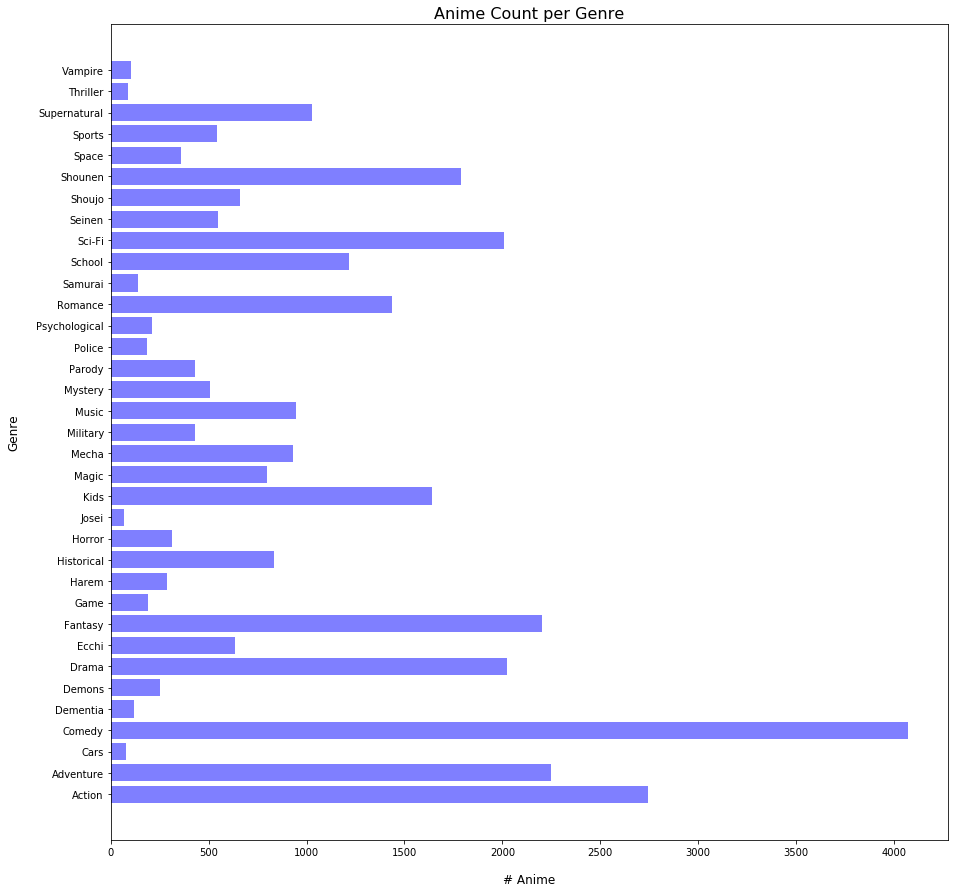

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

def genrePlot(df,genres):
    
    # get only the binary tags
    df_genres = df[genres]
    
    # we want to collect the genres that have more than 0 anime (can be possible due to preprocessing earlier)
    xlabels = []
    sums = []
    
    for genre in genres:
        
        count = sum(df[genre])
        
        if count>0:
            
            xlabels.append(genre)
            sums.append(count)
            
    # space out labels
    x_pos = np.arange(len(xlabels))
    
    # plotting
    plt.barh(x_pos, sums, align='center', alpha=0.5, color = 'b')
    plt.yticks(x_pos, xlabels)
    plt.xlabel('# Anime', fontsize = 12, labelpad=16)
    plt.ylabel('Genre', fontsize = 12, labelpad=16)
    plt.title('Anime Count per Genre', fontsize = 16)
    plt.show()
    return dict(zip(xlabels,sums))
    
    
genre_counts = genrePlot(df,genres)

** The data looks skewed, so we'll just be looking at the top 10 tags. **

In [96]:
sorted_vals = sorted(genre_counts.items(), key=lambda x: x[1], reverse = True)
chosen_genres = [genre for genre,count in sorted_vals[:10]]
chosen_genres

['Comedy',
 'Action',
 'Adventure',
 'Fantasy',
 'Drama',
 'Sci-Fi',
 'Shounen',
 'Kids',
 'Romance',
 'School']

In [101]:
new_columns = ['Anime', 'Synopsis'] + chosen_genres
df = df[new_columns]
df

,Anime,Synopsis,Comedy,Action,Adventure,Fantasy,Drama,Sci-Fi,Shounen,Kids,Romance,School
0,009-1,009-1\nStudios: Ishimori Entertainment\nRating...,0,1,0,0,0,1,0,0,0,0
1,009-1__R_B,009-1__R_B\nStudios: add some\nRating: R - 17+...,0,1,0,0,0,1,0,0,0,0
2,009_Re_Cyborg,009_Re_Cyborg\nStudios: Production I.G\nRating...,0,1,1,0,0,1,0,0,0,0
3,07-Ghost,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...,0,1,0,1,0,0,0,0,0,0
4,11-nin_Iru,11-nin_Iru\nStudios: add some\nRating: PG-13 -...,0,1,1,0,1,1,0,0,1,0
5,11eyes,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...,0,1,0,0,0,0,0,0,0,0
6,3x3_Eyes,3x3_Eyes\nStudios: Toei Animation\nRating: R -...,0,1,0,1,0,0,0,0,1,0
7,3x3_Eyes_Seima_Densetsu,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...,0,1,1,1,0,0,0,0,1,0
8,6_Angels,6_Angels\nStudios: add some\nRating: R+ - Mild...,0,1,0,0,0,1,0,0,0,0
9,91_Days,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...,0,1,0,0,1,0,0,0,0,0


### Note

So that we don't have to redo the above process everytime, we can pickle our final dataframe:

In [102]:
import pickle

# serialize dataframe for future use
df.to_pickle('anime_df.pkl')

In [103]:
# read in dataframe
df = pd.read_pickle('anime_df.pkl')

## III. Vectorize Text

In [117]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

X = np.asarray(df['Synopsis'])
y = np.asarray(df[df.columns.difference(['Anime','Synopsis'])])

sf = StratifiedShuffleSplit(n_splits = 1, train_size = .8, test_size = .2)

# separate into 80% training 20% testing set
for train_idx, test_idx in sf.split(X,y):
    
    X_train = X[train_idx]
    X_test = X[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]

### Bag of Words with scikit-learn

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# remove stop words and consider unigrams, bigrams and trigrams
count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 3), max_features = 50000)
X_train_count = count_vect.fit_transform(X_train)

### Tf-idf Transform

In [135]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_count)
X_train_tf = tf_transformer.transform(X_train_count)

In [136]:
# use fitted model to vectorize test data
X_test_count = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_count)

In [137]:
features = count_vect.get_feature_names()
pd.DataFrame(features)

,0
0,00
1,00 second
2,00 second season
3,00 version
4,00 version late
5,000
6,000 000
7,000 home
8,000 home shiomi
9,000 years


## IV. Test Different Classifiers

In this section we'll be testing different multi-label classifiers by performing grid search to optimize each parameter and returning the best results.

### 1) Naive Bayes

In [271]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier


parameters = [{'estimator__alpha' : [100,10,1,1e-1,1e-2,1e-3,1e-4]}]
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)
nb = MultinomialNB()
clf = GridSearchCV(OneVsRestClassifier(nb), parameters)

In [272]:
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [273]:
clf.score(X_train_tf,y_train)

0.80705319784817697

In [274]:
y_pred = clf.predict(X_test_tf)

In [275]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve

def reportMetrics(y_pred, y_actual):
    print('Accuracy: ' + str(accuracy_score(y_actual,y_pred)))
    print('F1 Score: ' + str(f1_score(y_actual,y_pred, average = 'macro')))
    print('Precision Score: ' + str(precision_score(y_actual,y_pred, average = 'macro')))
    print('Recall Score: ' + str(recall_score(y_actual,y_pred, average = 'macro')))
    

In [276]:
reportMetrics(y_pred, y_test)

Accuracy: 0.503824091778
F1 Score: 0.737630035518
Precision Score: 0.894395808049
Recall Score: 0.639879541765


### 2) Support Vector Machines

In [279]:
from sklearn.svm import SVC

parameters = [{'estimator__C': [10,1,1e-1,1e-2,1e-3], 'estimator__gamma': [1e-3, 1e-4],
               'estimator__kernel': ['linear', 'poly', 'rbf']}]
               

kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)
svc = SVC()
clf = GridSearchCV(OneVsRestClassifier(svc), parameters)

In [ ]:
clf.fit(X_train_tf,y_train)

In [231]:
# save SVC results
with open('SVC.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [287]:
# load classifier
with open('SVC.pkl', 'rb') as f:
    clf = pickle.load(f)

In [288]:
y_pred = clf.predict(X_test_tf)

In [289]:
reportMetrics(y_pred,y_test)

Accuracy: 0.616156787763
F1 Score: 0.790860182799
Precision Score: 0.836652883437
Recall Score: 0.752039066
